In [14]:
import pandas as pd
from glob2 import glob
from collections import defaultdict
import networkx as nx
from pathlib import Path

# Network Data

In [15]:
!tree 1_PPI_Network_data/

1_PPI_Network_data/
├── BioPlex_3
│   ├── BioPlex_net.tsv
│   └── BioPlex.tsv
├── CoFrac
│   ├── 41586_2015_BFnature14877_MOESM13_ESM.zip
│   ├── CoFrac_net.tsv
│   ├── __MACOSX
│   │   └── nature14871-s2
│   └── nature14871-s2
│       ├── Supplementary\ Table\ 1.\ Sample\ Information.xlsx
│       ├── Supplementary\ Table\ 2.\ PPIs\ Interologs\ and\ Corum.xlsx
│       ├── Supplementary\ Table\ 3.\ Predicted\ PPI\ across\ 122\ species.txt
│       ├── Supplementary\ Table\ 4.\ Final\ 981\ conserved\ protein\ complexes.xlsx
│       ├── Supplementary\ Table\ 5.\ Protein\ age\ and\ conservation\ profile\ across\ 122\ species.xlsx
│       ├── Supplementary\ Table\ 6.\ GOSlim\ domain\ diseaase\ and\ phenotype\ enrichment.xlsx
│       ├── Supplementary\ Table\ 7.\ Human\ disease\ annotation.xlsx
│       ├── Supplementary\ Table\ 8.\ Consecutive\ pathway\ and\ metabolic\ pairs.xlsx
│       └── Supplementary\ Table\ 9.\ 36\ common\ metabolites\ excluded\ from\ Recon2.txt
├── HuRI_db
│   ├── HI-u

In [16]:
Network_files = glob('1_PPI_Network_data//*/*_net.tsv')

Network_dfs = defaultdict(dict)
Network_Graphs = defaultdict(dict)
Network_Nodes = defaultdict(dict)



for Network_file in Network_files:
    Net_name = Network_file.split('/')[-1].replace('_net.tsv', '')
    df = pd.read_csv(Network_file, sep="\t")
    # print(df)
    Network_dfs[Net_name] = df
    G = nx.from_pandas_edgelist(df, 'IDa', 'IDb')
    G.remove_edges_from(nx.selfloop_edges(G))

    Network_Graphs[Net_name] = G
    
    # nodes = set(G.nodes)
    nodes = set(df.IDa.unique()).union(set(df.IDb.unique()))
    Network_Nodes[Net_name] = nodes
    # print(G)


    # break
    
list(Network_dfs), list(Network_Graphs), list(Network_Nodes)

(['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac'],
 ['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac'],
 ['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac'])

In [17]:
!tree HPIDB_data/

HPIDB_data/
├── Herpes
│   ├── Herpes_pathogen_species_201908.mitab.zip
│   ├── herpes_viruses_pathogen_species.mitab_plus_attr.txt
│   ├── herpes_viruses_pathogen_species.mitab_plus.tsv
│   ├── herpes_viruses_pathogen_species.mitab_plus.txt
│   └── herpes_viruses_pathogen_species.mitab.txt
└── Papillomaviruses
    ├── Papillomaviruses_pathogen_species_201908.mitab.zip
    ├── papillomaviruses_pathogen_species.mitab_plus_attr.txt
    ├── papillomaviruses_pathogen_species.mitab_plus.tsv
    ├── papillomaviruses_pathogen_species.mitab_plus.txt
    └── papillomaviruses_pathogen_species.mitab.txt

2 directories, 10 files


In [18]:
Viral_traget = defaultdict(dict)

Viral_files = glob('HPIDB_data/*/*.mitab_plus.tsv')
for Viral_file in Viral_files:
    V_name = Viral_file.split('/')[-1].split('_')[0].title()
    # print(V_name)
    df = pd.read_csv(Viral_file, sep="\t")
    # print(df)
    df_arrt = df.copy()
    df_arrt[list(df_arrt)[-1]] = V_name + "_target"
    df_arrt.to_csv(Viral_file.replace('mitab_plus.tsv', "mitab_plus_attr.txt"), index=False, sep=" ")
    Human_proteins = set(df.Human.unique())
    # print(Human_proteins)
    Viral_traget[V_name] = Human_proteins
    
    # break
    
list(Viral_traget)

['Papillomaviruses', 'Herpes']

In [19]:
from upsetplot import UpSet
from upsetplot import from_contents
from copy import copy


def Upset_protein(Target):
    
    Uset_data = defaultdict(dict)
    print('>', list(Network_Nodes))
    Uset_data = copy(Network_Nodes)
    Uset_data[Target] = Viral_traget[Target]

    print(list(Uset_data))    
    return Uset_data


# Upset_protein('Influenza')

> ['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac']
['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac', 'Papillomaviruses']


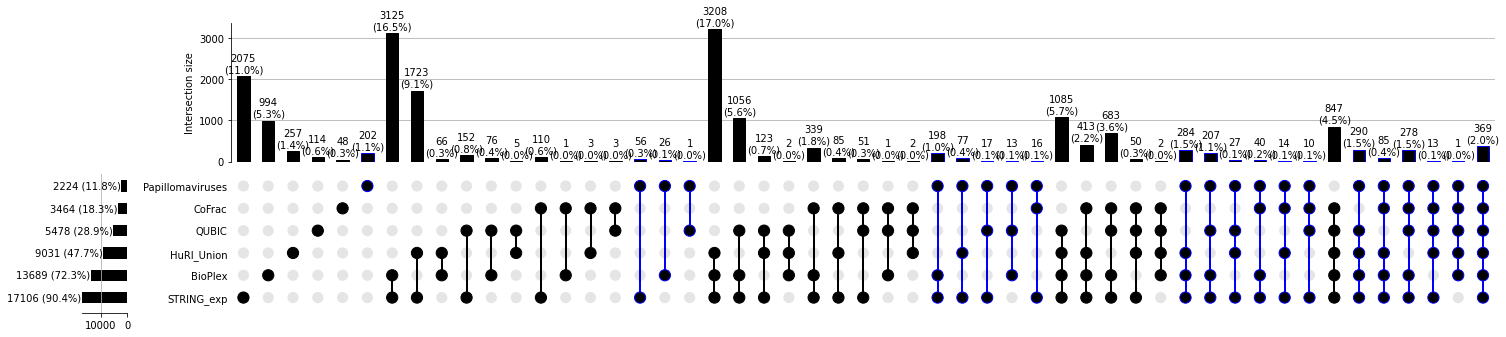

In [20]:
Data = Upset_protein('Papillomaviruses')
# print(list(Data))
Data = from_contents(Data)
Data
upset = UpSet(Data, show_counts='%d', show_percentages=True, shading_color=.0, other_dots_color=.1)

upset.style_subsets(present="Papillomaviruses", edgecolor="blue", linewidth=1)

upset.plot()
del(Data)


> ['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac']
['HuRI_Union', 'STRING_exp', 'QUBIC', 'BioPlex', 'CoFrac', 'Herpes']


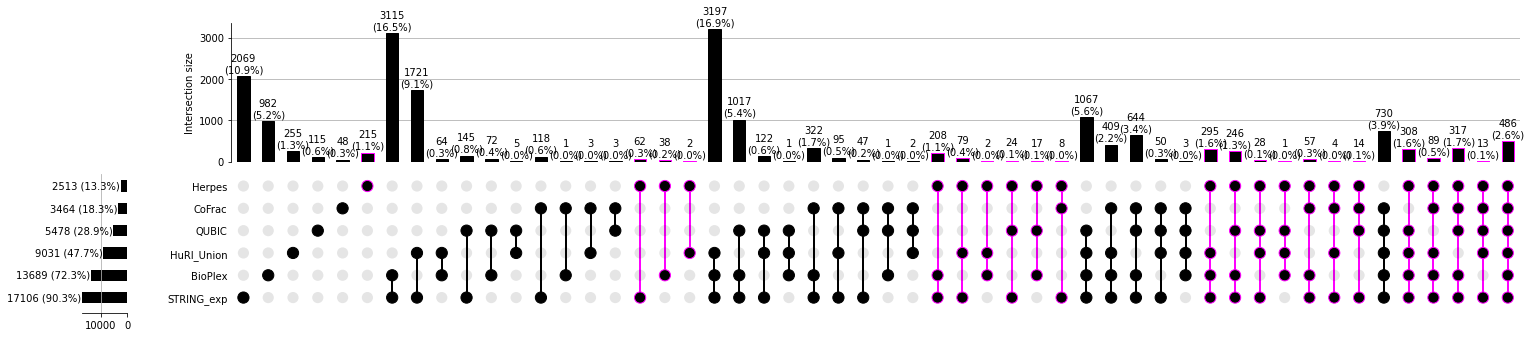

In [21]:
Data = Upset_protein('Herpes')

Data = from_contents(Data)
Data
upset = UpSet(Data, show_counts='%d', show_percentages=True, shading_color=.0, other_dots_color=.1)

upset.style_subsets(present="Herpes", edgecolor="magenta", linewidth=1)

upset.plot()
del(Data)


# Merge network

In [22]:
List_of_dfs = list(Network_dfs.values())

df_network = pd.concat(List_of_dfs)
df_network.drop_duplicates(inplace=True)

In [23]:
info = []

In [24]:
Network_Dir = "Network_data/"



def df_nx(df, Targets):
    LOL = df.values.tolist() #[:10]
    Open = []
    Close = []
    
    for a,b in LOL:
        # print(a,b)
        if a in Targets and b in Targets:
            Close.append([a,b])
        
        if a in Targets or b in Targets:
            Open.append([a,b])
    
    # print(len(LOL))
    # print(len(Close))
    # print(len(Open))
    
    O = nx.Graph()
    O.add_edges_from(Open)
    O.remove_edges_from(nx.selfloop_edges(O))
    
    C = nx.Graph()
    C.add_edges_from(Close)
    C.remove_edges_from(nx.selfloop_edges(C))

    print(O)
    print(C)
    return O, C
    
    

# O, C = df_nx(df, Viral_traget['Influenza'])
# Out_Dir = Network_Dir + "Influenza/"
# Path(Out_Dir).mkdir(parents=True, exist_ok=True)
# nx.write_edgelist(O, Out_Dir + 'Influenza' + "_Open_edgelist.nx", delimiter=' ', data=False)
# nx.write_edgelist(C, Out_Dir + 'Influenza' + "_Close_edgelist.nx", delimiter=' ', data=False)


In [26]:
# !tree RNASeq/**/*00_DEDeq2_Data*/*.csv
Herpes_df = pd.read_csv("RNASeq/Herpes_GSE124118/00_DEDeq2_Data_HSV/hsv_cells_Skin_vs_lung.csv")
Herpes_exp = set(Herpes_df[Herpes_df.padj <= 0.005].UNIPROT.dropna())

Papillomavirus_df = pd.read_csv("RNASeq/Papillomavirus_GSE74927/00_DEDeq2_Data_HPV/hpv_status_HPV_vs_Neg.csv")
Papillomavirus_exp = set(Papillomavirus_df[Papillomavirus_df.padj <= 0.005].UNIPROT.dropna())

len(Herpes_exp), len(Papillomavirus_exp)

(1163, 1777)

In [27]:

Count_info = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))



O, C = df_nx(df_network, Viral_traget['Herpes'])
Out_Dir = Network_Dir + "Herpes/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O, Out_Dir + 'Herpes' + "_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C, Out_Dir + 'Herpes' + "_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Herpes']['Viral_traget']['Open']['Node'] = O.number_of_nodes()
Count_info['Herpes']['Viral_traget']['Open']['Edges'] = O.number_of_edges()

Count_info['Herpes']['Viral_traget']['Close']['Node'] = C.number_of_nodes()
Count_info['Herpes']['Viral_traget']['Close']['Edges'] = C.number_of_edges()


# # print(nx.to_pandas_edgelist(O))

O_exp_O, O_exp_C = df_nx(nx.to_pandas_edgelist(O), Herpes_exp)
Out_Dir = Network_Dir + "Herpes/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O_exp_O, Out_Dir + 'Herpes' + "_Open_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(O_exp_C, Out_Dir + 'Herpes' + "_Open_exp_Close_edgelist.nx", delimiter=' ', data=False)


Count_info['Herpes']['Viral_expressed_open']['Open']['Node'] = O_exp_O.number_of_nodes()
Count_info['Herpes']['Viral_expressed_open']['Open']['Edges'] = O_exp_O.number_of_edges()

Count_info['Herpes']['Viral_expressed_open']['Close']['Node'] = O_exp_C.number_of_nodes()
Count_info['Herpes']['Viral_expressed_open']['Close']['Edges'] = O_exp_C.number_of_edges()

C_exp_O, C_exp_C = df_nx(nx.to_pandas_edgelist(C), Herpes_exp)
Out_Dir = Network_Dir + "Herpes/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(C_exp_O, Out_Dir + 'Herpes' + "_Close_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C_exp_C, Out_Dir + 'Herpes' + "_Close_exp_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Herpes']['Viral_expressed_close']['Open']['Node'] = C_exp_O.number_of_nodes()
Count_info['Herpes']['Viral_expressed_close']['Open']['Edges'] = C_exp_O.number_of_edges()

Count_info['Herpes']['Viral_expressed_close']['Close']['Node'] = C_exp_C.number_of_nodes()
Count_info['Herpes']['Viral_expressed_close']['Close']['Edges'] = C_exp_C.number_of_edges()


pd.concat({k: pd.DataFrame(v).T for k, v in Count_info.items()}, axis=0)

Graph with 16556 nodes and 247919 edges
Graph with 2263 nodes and 50367 edges
Graph with 8012 nodes and 25918 edges
Graph with 485 nodes and 798 edges
Graph with 1581 nodes and 5055 edges
Graph with 93 nodes and 133 edges


Open  \
Herpes Viral_traget           {'Node': 16556, 'Edges': 247919}   
       Viral_expressed_open     {'Node': 8012, 'Edges': 25918}   
       Viral_expressed_close     {'Node': 1581, 'Edges': 5055}   

                                                       Close  
Herpes Viral_traget           {'Node': 2263, 'Edges': 50367}  
       Viral_expressed_open      {'Node': 485, 'Edges': 798}  
       Viral_expressed_close      {'Node': 93, 'Edges': 133}

In [29]:

pd.concat({k: pd.DataFrame(v).T for k, v in Count_info.items()}, axis=0)

Open  \
Herpes Viral_traget           {'Node': 16556, 'Edges': 247919}   
       Viral_expressed_open     {'Node': 8012, 'Edges': 25918}   
       Viral_expressed_close     {'Node': 1581, 'Edges': 5055}   

                                                       Close  
Herpes Viral_traget           {'Node': 2263, 'Edges': 50367}  
       Viral_expressed_open      {'Node': 485, 'Edges': 798}  
       Viral_expressed_close      {'Node': 93, 'Edges': 133}

In [30]:
O, C = df_nx(df_network, Viral_traget['Papillomaviruses'])
Out_Dir = Network_Dir + "Papillomaviruses/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O, Out_Dir + 'Papillomaviruses' + "_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C, Out_Dir + 'Papillomaviruses' + "_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Papillomaviruses']['Viral_traget']['Open']['Node'] = O.number_of_nodes()
Count_info['Papillomaviruses']['Viral_traget']['Open']['Edges'] = O.number_of_edges()

Count_info['Papillomaviruses']['Viral_traget']['Close']['Node'] = C.number_of_nodes()
Count_info['Papillomaviruses']['Viral_traget']['Close']['Edges'] = C.number_of_edges()

O_exp_O, O_exp_C = df_nx(nx.to_pandas_edgelist(O), Papillomavirus_exp)
Out_Dir = Network_Dir + "Papillomaviruses/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O_exp_O, Out_Dir + 'Papillomaviruses' + "_Open_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(O_exp_C, Out_Dir + 'Papillomaviruses' + "_Open_exp_Close_edgelist.nx", delimiter=' ', data=False)


Count_info['Papillomaviruses']['Viral_expressed_open']['Open']['Node'] = O_exp_O.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_open']['Open']['Edges'] = O_exp_O.number_of_edges()

Count_info['Papillomaviruses']['Viral_expressed_open']['Close']['Node'] = O_exp_C.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_open']['Close']['Edges'] = O_exp_C.number_of_edges()


C_exp_O, C_exp_C = df_nx(nx.to_pandas_edgelist(C), Papillomavirus_exp)
Out_Dir = Network_Dir + "Papillomaviruses/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(C_exp_O, Out_Dir + 'Papillomaviruses' + "_Close_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C_exp_C, Out_Dir + 'Papillomaviruses' + "_Close_exp_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Papillomaviruses']['Viral_expressed_close']['Open']['Node'] = C_exp_O.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_close']['Open']['Edges'] = C_exp_O.number_of_edges()

Count_info['Papillomaviruses']['Viral_expressed_close']['Close']['Node'] = C_exp_C.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_close']['Close']['Edges'] = C_exp_C.number_of_edges()


Graph with 16226 nodes and 207844 edges
Graph with 1977 nodes and 32875 edges
Graph with 9431 nodes and 34490 edges
Graph with 789 nodes and 1559 edges
Graph with 1521 nodes and 5403 edges
Graph with 138 nodes and 243 edges


In [31]:
pd.concat({k: pd.DataFrame(v).T for k, v in Count_info.items()}, axis=0)

Open  \
Herpes           Viral_traget           {'Node': 16556, 'Edges': 247919}   
                 Viral_expressed_open     {'Node': 8012, 'Edges': 25918}   
                 Viral_expressed_close     {'Node': 1581, 'Edges': 5055}   
Papillomaviruses Viral_traget           {'Node': 16226, 'Edges': 207844}   
                 Viral_expressed_open     {'Node': 9431, 'Edges': 34490}   
                 Viral_expressed_close     {'Node': 1521, 'Edges': 5403}   

                                                                 Close  
Herpes           Viral_traget           {'Node': 2263, 'Edges': 50367}  
                 Viral_expressed_open      {'Node': 485, 'Edges': 798}  
                 Viral_expressed_close      {'Node': 93, 'Edges': 133}  
Papillomaviruses Viral_traget           {'Node': 1977, 'Edges': 32875}  
                 Viral_expressed_open     {'Node': 789, 'Edges': 1559}  
                 Viral_expressed_close     {'Node': 138, 'Edges': 243}

In [32]:
!tree Network_data

Network_data
├── Herpes
│   ├── Herpes_Close_edgelist.nx
│   ├── Herpes_Close_exp_Close_edgelist.nx
│   ├── Herpes_Close_exp_Open_edgelist.nx
│   ├── Herpes_Open_edgelist.nx
│   ├── Herpes_Open_exp_Close_edgelist.nx
│   └── Herpes_Open_exp_Open_edgelist.nx
└── Papillomaviruses
    ├── Papillomaviruses_Close_edgelist.nx
    ├── Papillomaviruses_Close_exp_Close_edgelist.nx
    ├── Papillomaviruses_Close_exp_Open_edgelist.nx
    ├── Papillomaviruses_Open_edgelist.nx
    ├── Papillomaviruses_Open_exp_Close_edgelist.nx
    └── Papillomaviruses_Open_exp_Open_edgelist.nx

2 directories, 12 files
